In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Global variable to store cached data in memory
global_cache_data_analog = None
global_processed_files_analog = None
global_cache_data_digital = None
global_processed_files_digital = None

In [2]:
import os
import pickle
import re
import numpy as np
from pathlib import Path


def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        df = clean_array(df)
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]

        fidelity =df['avg_fidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        try:
            test_results =  np.asarray(df['fidelities'][0], dtype=np.float64)
        except KeyError:
            
            test_results =  np.asarray(df['testing_results'][0], dtype=np.float64)
        num_epochs = df['epochs'][0]
        return costs, fidelity, num_params, test_results,grads_per_epoch
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data
    
def get_cached_data_once_digital(base_path):
    """Load cached data only once and keep it in memory for future runs for the digital model."""
    global global_cache_data_digital, global_processed_files_digital

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_digital is not None and global_processed_files_digital is not None:
        return global_cache_data_digital, global_processed_files_digital

    # Load the cache from disk (only happens once)
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    if os.path.exists(cache_file):
        if os.stat(cache_file).st_size == 0:
            print(f"[ERROR] Cache file {cache_file} is empty. Returning empty cache.")
            global_cache_data_digital = {}
            global_processed_files_digital = set()
            return global_cache_data_digital, global_processed_files_digital

        try:
            with open(cache_file, 'rb') as f:
                global_cache_data_digital, global_processed_files_digital = pickle.load(f)
            global_cache_data_digital = clean_array(global_cache_data_digital)

            # Filter the cache to only include files from the correct base path
            global_processed_files_digital = set(
                file for file in global_processed_files_digital if file.startswith(base_path)
            )
            return global_cache_data_digital, global_processed_files_digital
        except (EOFError, pickle.UnpicklingError) as e:
            print(f"[ERROR] Failed to load cache file {cache_file}: {e}")
            global_cache_data_digital = {}
            global_processed_files_digital = set()
            return global_cache_data_digital, global_processed_files_digital
    else:
        print(f"[INFO] Cache file {cache_file} does not exist. Creating empty cache.")
        global_cache_data_digital = {}
        global_processed_files_digital = set()
        return global_cache_data_digital, global_processed_files_digital

def clean_cached_data_with_missing_paths(cached_data):
    """
    Remove entries from the cached data where 'path' is None.
    """
    for N_ctrl, gates in cached_data.items():
        for gate, reservoirs in gates.items():
            for reservoir_count, trotter_steps in reservoirs.items():
                for trotter_step, data_points in trotter_steps.items():
                    valid_data_points = [dp for dp in data_points if dp.get('path') is not None]
                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = valid_data_points
    return cached_data


def retrofit_cached_data_with_path(base_path, cached_data):
    """
    Adds the 'path' key to cached data if it doesn't exist.
    """
    for N_ctrl, gates in cached_data.items():
        for gate, reservoirs in gates.items():
            for reservoir_count, trotter_steps in reservoirs.items():
                for trotter_step, data_points in trotter_steps.items():
                    for data_point in data_points:
                        if 'path' not in data_point:
                            # Attempt to reconstruct the file path
                            trotter_path = os.path.join(
                                base_path,
                                gate,
                                f"reservoirs_{reservoir_count}",
                                f"trotter_step_{trotter_step}",
                            )
                            # Example logic: Assume file names can be inferred from 'run' key
                            if 'run' in data_point:
                                file_name = f"{data_point['run']}.pickle"
                                file_path = os.path.join(trotter_path, file_name)
                                if os.path.exists(file_path):
                                    data_point['path'] = file_path
                                else:
                                    data_point['path'] = None  # Mark as unknown if file is missing
                            else:
                                data_point['path'] = None  # Mark as unknown if 'run' is missing
    return cached_data

def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and list of processed files to cache stored in the base_path."""
    cache_file = os.path.join(base_path, f'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)

                                    # Count data runs already in cache
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or 'gate' not in cached_result or cached_result['path'] != pickle_file:
                                                        cached_result['run'] = run
                                                        cached_result['gate'] = gate
                                                # print(f"Data missing from")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                     
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                # Extract just the data_run_<i> part from the file name
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch':grads_per_epoch,
                                                    # 'selected_indices':selected_indices
                                                }

                                                # Append the new data point to the cache
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)


                                                
                                                processed_files.add(pickle_file)  # Mark file as processed

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files
def process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                # Ensure that N_ctrl is a top-level key in the cache
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                        

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                    current_best_data_point = None
                                    num_data_runs = 0

                                    # Check if there's already cached data for this trotter step
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    missing_paths = 0  # Counter for entries with missing paths

                                    # Retrofit 'path' for cached data if missing
                                    for data_point in cached_trotter_data:
                                        if 'path' not in data_point or data_point['path'] is None:
                                            run = data_point.get('run', None)
                                            if run:
                                                potential_file_path = os.path.join(trotter_path, f"{run}.pickle")
                                                if not potential_file_path.startswith('/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_20_optimized_by_cost3/'):
                                                    print(f"Incorrect filepath: {potential_file_path}")
                                                
                                                if os.path.exists(potential_file_path):
                                                    data_point['path'] = potential_file_path
                                                else:
                                                    missing_paths += 1
                                        # else:
                                        #     files_to_check = [
                                        #             file for file in processed_files 
                                        #             if not file.startswith('/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_20_optimized_by_cost3/')
                                        #         ]

                                        #     if files_to_check:
                                        #         print("Files found matching the criteria:")
                                        #         for file in files_to_check:
                                        #             print(file)
                                        #     else:
                                        #         print("No files found matching the criteria.")

                                        #     print(f"Path apparently found")
                                    # if cached_trotter_data:
                                    #     current_best_data_point = cached_trotter_data[0]  # Assuming one best result per trotter step
                                    #     current_best_fidelity = np.mean(current_best_data_point['fidelity'])
                                    #     num_data_runs = current_best_data_point.get('num_data_runs', 0)
                                    if missing_paths > 0:
                                        print(
                                            f"[WARNING] {missing_paths} data points missing files for "
                                            f"N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}"
                                        )
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Ensure the file belongs to the correct base path
                                            # if not pickle_file.startswith(base_path):
                                            #     continue

                                            # Check if the file has been processed before
                                            if pickle_file not in processed_files and is_valid_pickle_file(Path(pickle_file)):
                                                # Process the file and find the fidelity
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Check if this new file has a better fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,
                                                        'num_data_runs': num_data_runs,
                                                        'grads_per_epoch': grads_per_epoch,
                                                        'path': pickle_file,  # Add path here
                                                    }
                                                processed_files.add(pickle_file)


                                    # If we found a valid data point with better fidelity, cache it
                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]
                                        # processed_files.add(pickle_file)  # Mark file as processed

    return cached_data, processed_files

# Initialization and execution
N_ctrls = [1,2,3]
num_train = 20
reservoir_counts = [1,2,3,4,5,6,7,8,9,10]
# reservoir_counts = [1,2,3,4,5,6,7,8,9]
processed_files_global_digital = set()
base_path = f'/Users/so714f/Documents/offline/qrc/gate_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_costcut_1e-10/'
# base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{num_train}_epoch1500_per_param_costcut_1e-10/'

cached_data_digital, processed_files_digital = get_cached_data_once_digital(base_path)



In [3]:

for N_ctrl in N_ctrls:

    gate_prefixes = [f'U{N_ctrl}']
    


    trots = np.arange(1, 54, 1)

    # Process files and update the cache for digital
    cached_data_digital, processed_files_digital = process_new_files_digital(
        base_path, gate_prefixes, reservoir_counts, trots, 
        cached_data_digital, processed_files_digital, N_ctrl
    )

    # Save the updated cache for digital
    save_cached_data(base_path, cached_data_digital, processed_files_digital)

    # Update global processed files set for digital
    processed_files_global_digital.update(processed_files_digital)

Processing for N_ctrl = 1
Processing for N_ctrl = 2
Processing for N_ctrl = 3


In [11]:
import os
import pickle
import re
import numpy as np
from pathlib import Path

def inspect_cache_file(cache_path):
    """Inspect the contents of the cached_results.pkl file and print the number of processed files for each N_ctrl."""
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            try:
                cached_data, processed_files = pickle.load(f)
                print(f"Cache file loaded successfully from: {cache_path}")

                # Print the total number of processed files
                print(f"\n---- Total Number of Processed Files: {len(processed_files)} ----")

                print("\n---- Number of Processed Files for Each N_ctrl ----")
                for N_ctrl, gates_data in cached_data.items():
                    # Calculate the number of processed files for this N_ctrl
                    num_processed_for_ctrl = sum(
                        len(runs_data) for gate_data in gates_data.values()
                        for reservoir_data in gate_data.values()
                        for runs_data in reservoir_data.values()
                    )
                    print(f"N_ctrl={N_ctrl}: {num_processed_for_ctrl} processed files.")

            except (EOFError, pickle.UnpicklingError) as e:
                print(f"Error loading cache file: {e}")
    else:
        print(f"Cache file not found: {cache_path}")
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data  # Return as is if not an array or collection

def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        
    # Clean any deprecated arrays in the data
    df = clean_array(df)
    with open(file_path, 'wb') as f:
        
        pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)
    costs = [float(i) for i in df['costs'][0]]
    fidelity = df['avg_fidelity'][0]
    test_results = [float(a) for a in df['testing_results'][0]]
    num_params = 3 + int(df['trotter_step'][0]) + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
    grads_per_epoch = df['grads_per_epoch'][0]
    try:
        selected_indices = df['selected_indices'][0]
    except KeyError:
        selected_indices = None
    return costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices



def get_cached_data(cache_file):
    """Load cached data and list of processed files from a specified cache path."""
    start_time = time.time()
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
            # Clean arrays to ensure compatibility
            cached_data = clean_array(cached_data)
        load_time = time.time() - start_time
        print(f"Loaded {len(processed_files)} processed files from cache. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file not found: {cache_file}")
        return {}, set()
def get_cached_data_once(base_path, N_ctrl = None):
    """Load cached data only once and keep it in memory for future runs, with different cache paths based on N_ctrl."""
    global global_cache_data_analog, global_processed_files_analog
    start_time = time.time()

    # Define cache file based on N_ctrl
   
    cache_file = os.path.join(base_path, 'cached_results.pkl')

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_analog is not None and global_processed_files_analog is not None:
        print("Using cached data from memory, not reloading from disk.")
        return global_cache_data_analog, global_processed_files_analog

    # Load the cache from disk (only happens once)
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data_analog, global_processed_files_analog = pickle.load(f)
        print(f"Cache file loaded from disk: {cache_file}")
        global_cache_data_analog = clean_array(global_cache_data_analog)
        load_time = time.time() - start_time
        print(f"Loaded {len(global_processed_files_analog)} processed files from cache. Took {load_time:.2f}s.")
        return global_cache_data_analog, global_processed_files_analog
    else:
        print(f"Cache file not found: {cache_file}")
        global_cache_data_analog = {}
        global_processed_files_analog = set()
        return global_cache_data_analog, global_processed_files_analog
def get_cached_data_for_N_ctrl(base_path, N_ctrl = 1):
    """Load cached data specific to the given N_ctrl value and return its contents."""
    cache_file = os.path.join(base_path, f'results_Nc_{N_ctrl}.pkl')
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set()  # Return empty structures if no cache exists
def get_cached_data_direct_path(cache_file, N_ctrl):
    """Load cached data specific to the given N_ctrl value and return its contents."""
    
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set() 
def save_cached_data_for_N_ctrl(base_path, cached_data, processed_files, N_ctrl):
    """Save cached data and processed files specific to the given N_ctrl value."""
    cache_file = os.path.join(base_path, f'results_Nc_{N_ctrl}.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
    print(f"Cache for N_ctrl={N_ctrl} saved to {cache_file}")


def process_files_by_N_ctrl(base_path, gate_prefixes, reservoir_counts, trots, N_ctrl):
    """Main process to load, update, and save cache for each N_ctrl."""
    # Load cached data for current N_ctrl
    cached_data, processed_files = get_cached_data_for_N_ctrl(base_path, N_ctrl)

    # Process new files and update the cache
    cached_data, processed_files = process_new_files(
        base_path, gate_prefixes, reservoir_counts, trots,
        cached_data, processed_files, N_ctrl
    )

    # Save the updated cache for current N_ctrl
    save_cached_data_for_N_ctrl(base_path, cached_data, processed_files, N_ctrl)

def get_cached_data_direct_path(filepath, N_ctrl):
    start_time = time.time()
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files

def process_files_by_direct_path(filepath, gate_prefixes, reservoir_counts, trots, N_ctrl):
    """Main process to load, update, and save cache for each N_ctrl."""
    # Load cached data for current N_ctrl
    cached_data, processed_files = get_cached_data_direct_path(filepath, N_ctrl)

    # Process new files and update the cache
    cached_data, processed_files = process_new_files(
        filepath, gate_prefixes, reservoir_counts, trots,
        cached_data, processed_files, N_ctrl
    )





def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and processed files."""
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)

def process_new_files(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                # Ensure N_ctrl is in cached_data
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}
                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')
                                    current_best_data_point = None
                                    num_data_runs = 0

                                    # Check if there's already cached data for this trotter step
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    missing_paths = 0  # Counter for entries with missing paths

                                    for data_point in cached_trotter_data:
                                        if 'file_path' not in data_point or data_point['file_path'] is None:
                                            run = data_point.get('run', None)
                                            if run:
                                                potential_file_path = os.path.join(trotter_path, f"{run}.pickle")
                                                if not potential_file_path.startswith(base_path):
                                                    print(f"Incorrect filepath: {potential_file_path}")
                                                
                                                if os.path.exists(potential_file_path):
                                                    data_point['file_path'] = potential_file_path
                                                else:
                                                    missing_paths += 1
                                    
                                    if missing_paths > 0:
                                        print(
                                            f"[WARNING] {missing_paths} data points missing files for "
                                            f"N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}"
                                        )
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # # Ensure the file belongs to the correct base path
                                            # if not pickle_file.startswith(base_path):
                                            #     continue

                                            # Check if the file has already been processed
                                            if pickle_file not in processed_files and is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices = read_jax_file(pickle_file, gate)
                                                run = os.path.basename(pickle_file).replace('.pickle', '')
                                                num_data_runs += 1  # Increment the number of data runs

                                                # Process the file if it's valid
                                                if is_valid_pickle_file(Path(pickle_file)):
                                                    # if N_ctrl == 2 and trotter_step >20:
                                                    #     print(pickle_file)
                                                    costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices = read_jax_file(pickle_file, gate)

                                                    # Update the best fidelity
                                                    if fidelity > current_best_fidelity:
                                                        current_best_fidelity = fidelity
                                                        current_best_data_point = {
                                                            'costs': costs,
                                                            'gate': gate,
                                                            'fidelity': fidelity,
                                                            'test_results': test_results,
                                                            'param_count': num_params,
                                                            'run': run,  # Store the data_run_<i> value
                                                            'grads_per_epoch': grads_per_epoch,
                                                            'selected_indices': selected_indices,
                                                            'file_path': pickle_file  # Add the file path
                                                        }

                                                    # Add processed file to the global set
                                                    processed_files.add(pickle_file)

                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]

    return cached_data, processed_files


def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                # print(f"Processing gate: {gate}")

                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue
                            # print(f"Processing reservoir: {reservoir_count}")

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue
                                    # print(f"Processing trotter step: {trotter_step}")

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    # Ensure that N_ctrl is in cached_data
                                    if N_ctrl not in cached_data:
                                        cached_data[N_ctrl] = {}

                                    # Initialize the cached_trotter_data
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # print(f"Skipping file {pickle_file}, already processed.")
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or cached_result['run'] != run:
                                                        cached_result['run'] = run
                                                    if 'gate' not in cached_result or cached_result['gate'] != gate:
                                                        cached_result['gate'] = gate
                                                    
                                                    # # Load file and check for 'selected_indices'
                                                    # if 'selected_indices' not in cached_result:
                                                    #     print(f"Missing data in {pickle_file}, adding now...")
                                                    #     with open(pickle_file, 'rb') as f:
                                                    #         df = pickle.load(f)
                                                    #         if 'selected_indices' in df:
                                                    #             selected_indices = df['selected_indices'][0]
                                                    #             cached_result['selected_indices'] = selected_indices
                                                    #             print(f"Added selected indices {selected_indices} to test {gate}, dt: {trotter_step} for run {run} to cache")
                                                    #         else:
                                                    #             print(f"No 'selected_indices' found in file: {pickle_file}")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results,grads_per_epoch,selected_indices = read_jax_file(pickle_file, gate)
                                                avg_fidelity = np.mean(test_results)

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                                # Increment the data run count since we're adding a new run
                                                num_data_runs += 1

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch':grads_per_epoch,
                                                    'path':pickle_file
                                                    # 'selected_indices':selected_indices
                                                }

                                                # Append the new data point to the cache
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)

                                                # Mark the file as processed
                                                processed_files.add(pickle_file)
                                                print(f"Added new file to cache: {pickle_file}")

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files







num_epochs = 1500
# # Process files by each N_ctrl and update the cache independently
# cached_data_analog_nctrl3 , processed_files_analog_nctrl3 = get_cached_data_direct_path(nctrl3_path, N_ctrl)
# Main loop for different N_ctrl values
N_ctrls = [1, 2,3]
num_train = 20
reservoir_counts = [1, 2, 3,4,5,6,7,8]
base_path = f'/Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_{num_train}_epoch{num_epochs}_per_param_opt/0/'
# base_path = f'/Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_{num_train}_epoch1000/0/'
cached_data_analog, processed_files_analog = get_cached_data_once(base_path)

Cache file loaded from disk: /Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_20_epoch1500_per_param_opt/0/cached_results.pkl
Loaded 909 processed files from cache. Took 56.35s.


In [12]:
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    


    trots = np.arange(1, 54, 1)

    # Process files and update the cache
    cached_data_analog, processed_files_analog = process_new_files(base_path, gate_prefixes, reservoir_counts, trots, cached_data_analog, processed_files_analog, N_ctrl)
  
    save_cached_data(base_path, cached_data_analog, processed_files_analog)

    global_processed_files_analog.update(processed_files_analog)

    

In [4]:
cached_data_digital.keys()

dict_keys([2, 3])

In [9]:
def get_dataframe(cached_data_temp, model_type = "Digital"):
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        original = results.get('test_results', [])
                        new_vals = []
                        for f in original:
                            if f > 1.0:
                                delta = f - 1.0       # how far above 1.0
                                reflected = 1.0 - delta  # reflect about 1.0
                                # If 'reflected' dips below 0 (which can happen if f>2),
                                # you might clamp it to 0.0 or do something else:
                                if reflected < 0:
                                    reflected = 0.0
                                print(f"[PASS 1] Reflecting fidelity {f:.6f} about 1.0 => {reflected:.6f} "
                                    f"(Gate={gate}, N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step})")
                                new_vals.append(reflected)
                            else:
                                new_vals.append(f)
                        results['test_results'] = new_vals
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        # Just clamp any test_results fidelity to <= 1.0
                        original = results.get('test_results', [])
                        clamped_vals = [min(1.0, f) for f in original]
                        results['test_results'] = clamped_vals
                        
    tmp_rows = []
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        row = {
                            'Type': model_type,
                            'N_C': N_ctrl,
                            'Gate': gate,
                            'N_R': reservoir_count,
                            'Trotter_Step': trotter_step,
                        }
                        # Include *all* keys from `results` so we don't drop anything
                        for k, v in results.items():
                            row[k] = v

                        tmp_rows.append(row)

    tmp_df = pd.DataFrame(tmp_rows)
        
   

    def keep_iqr_5_95(arr):
        # If array empty or all identical, just return it
        if len(arr) < 2:
            return arr
        p5, p95 = np.percentile(arr, [5, 95])
        filtered = [x for x in arr if p5 <= x <= p95]
        # If everything got filtered out, you could decide to keep them all
        # or do something else. Here we allow an empty list if it's all outliers.
        return filtered if filtered else arr
    # def keep_iqr_10_90(arr):
    #     # If array empty or all identical, just return it
    #     if len(arr) < 2:
    #         return arr
    #     p5, p95 = np.percentile(arr, [10, 90])
    #     filtered = [x for x in arr if p5 <= x <= p95]
    #     # If everything got filtered out, you could decide to keep them all
    #     # or do something else. Here we allow an empty list if it's all outliers.
    #     return filtered if filtered else arr
    tmp_df['test_results'] = tmp_df['test_results'].apply(keep_iqr_5_95)

    # suspicious = tmp_df[
    #     (tmp_df['N_C']==2) & 
    #     (tmp_df['N_R']==1) & 
    #     (tmp_df['Trotter_Step']==16) &
    #      (tmp_df['Gate'] == 'U2_0') # or whichever row shows local_max=1.0
    # ]
    # print("Result after pass filtering IQR 5/95")
    # for idx, row in suspicious.iterrows():
    #     arr = row['test_results']
    #     print(f"\nGate={row['Gate']} => test_results stats:")
    #     print(f"  Min={np.min(arr):.7e}, Max={np.max(arr)}, Var={np.var(arr)}, Mean={np.mean(arr):.9f}")

    tmp_df['avg_fidelity'] = tmp_df['test_results'].apply(
        lambda arr: np.mean(arr) if len(arr) else 1.0
    )

    group_cols = ['N_C', 'N_R', 'Trotter_Step']
    tmp_df['local_max_avg_fid'] = (
        tmp_df.groupby(group_cols)['avg_fidelity'].transform('max')
    )


    def fix_any_ones_partially(row):
        arr = row['test_results']
        if len(arr) > 0 and any(x == 1.0 for x in arr):
            local_max = row['local_max_avg_fid']
            new_arr = []
            for x in arr:
                if x == 1.0:
                    new_arr.append(local_max)
                else:
                    new_arr.append(x)
            print(f"[PASS 2] Partially replacing any 1.0 entries "
                f"with local_max_avg_fid={local_max:.4e} "
                f"(Gate={row['Gate']}, N_C={row['N_C']}, "
                f"N_R={row['N_R']}, T={row['Trotter_Step']})")
            return new_arr
        return arr
    tmp_df['test_results'] = tmp_df.apply(fix_any_ones_partially, axis=1)

    
    ##############################################################################
    # WRITE BACK THE UPDATED `test_results` INTO `cached_data_temp`
    # so your original code snippet can run unmodified.
    ##############################################################################
    for idx, row in tmp_df.iterrows():
        N_ctrl = row['N_C']
        gate = row['Gate']
        reservoir_count = row['N_R']
        trotter_step = row['Trotter_Step']
        
        # Find matching entry in the results_list
        results_list = cached_data_temp[N_ctrl][gate][reservoir_count][trotter_step]
        found_entry = False
        for results in results_list:
            # If you have a unique 'run' key, match on that
            if 'run' in row and results.get('run') == row['run']:
                results['test_results'] = row['test_results']
                found_entry = True
                break

        # If you have no unique ID, you must figure out a safe way to match
        # For now, we skip if not found:
        if not found_entry:
            pass



    ##############################################################################
    # PASS 2: RUN YOUR ORIGINAL CODE TO BUILD THE FINAL `all_data_df` WITH ALL KEYS
    ##############################################################################
    rows = []
    negative_fidelity_values = []

    global_min_error = 100  # from your snippet
    N_ctrls = [2,3]        # or whatever your loop over N_ctrl is

    for N_ctrl in N_ctrls:
        data_i = cached_data_temp[N_ctrl]
        for gate, gate_data in data_i.items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        avg_fidelity = results.get('fidelity', np.nan)
                        std_fidelity = np.nanstd(results.get('test_results', []))

                        if pd.isna(avg_fidelity):
                            raise ValueError(
                                f"NaN in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                                f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, "
                                f"Run: {results.get('run', None)}"
                            )

                        log_infidelities = []
                        infidelities, fidelities = [], []
                        num_clipped = {}
                        all_og_fidelities = {}

                        test_results = results.get('test_results', [])
                        optimal_min_error = None
                        optimal_jitter_scale = None

                        # Step 1: dynamic min_error + jitter
                        non_clipped_fids = [
                            f for f in test_results
                            if 0 < f < 1.0
                        ]
                        if non_clipped_fids:
                            sorted_valid = sorted(non_clipped_fids)
                            n = len(sorted_valid)
                            std_dev = np.std(sorted_valid)
                            std_err = std_dev / np.sqrt(n) if n > 1 else global_min_error
                            optimal_min_error = 1.0 - sorted_valid[-1]
                            if global_min_error > optimal_min_error:
                                global_min_error = max(1e-9, optimal_min_error)
                            optimal_jitter_scale = (
                                std_dev / 2
                                if std_dev/2 < optimal_min_error
                                else optimal_min_error
                            )
                        else:
                            optimal_min_error = global_min_error
                            optimal_jitter_scale = global_min_error

                        # Step 2: Process each fidelity
                        clipped_count = 0
                        for i, f in enumerate(test_results):
                            all_og_fidelities[i] = f
                            inf = 1.0 - f

                            if inf <= 1e-8:
                                clipped_count += 1
                                jitter = np.random.uniform(-optimal_jitter_scale, 
                                                        optimal_jitter_scale)
                                num_clipped[i] = {'fidelity': f, 'jit': jitter}
                                inf = optimal_min_error + jitter
                                # print(f'triggered')
                                # print(f"\nGate={results['gate']} => test_results stats:")
                                # print(f"  Min={np.min(test_results):.7e}, Max={np.max(test_results)}, Var={np.var(test_results)}, Mean={np.mean(test_results):.9f}")
                                assert inf > 0, (
                                    f"Adjusted infidelity is non-positive: i={i}, "
                                    f"min_error={optimal_min_error}, jitter={jitter}."
                                )
                                f = 1.0 - inf

                            infidelities.append(inf)
                            fidelities.append(f)
                            log_infidelities.append(np.log10(inf))

                        # Step 3: Build row
                        avg_fidelity = np.mean(fidelities)
                        avg_infidelity = np.mean(infidelities)

                        row = {
                            'Type': model_type,
                            'N_C': int(N_ctrl),
                            'Trotter_Step': int(trotter_step),
                            'Gate': results['gate'],
                            'N_R': int(reservoir_count),
                            'Avg_Fidelity': avg_fidelity,
                            'std_fidelity': std_fidelity,
                            'Avg_infidelity': avg_infidelity,
                            'var_infid': np.var(infidelities),
                            'Error_Test_Results': log_infidelities,
                            'Avg Error': (np.nanmean(log_infidelities) 
                                        if log_infidelities else np.nan),
                            'infidelities': infidelities,
                            'Costs': results.get('costs', []),
                            'Test Results': test_results,
                            'N_params': results.get('param_count', np.nan),
                            'run': results.get('run', None),
                            'indices_clipped': num_clipped,
                            'all_og': all_og_fidelities,
                            'Optimal_min_error': optimal_min_error,
                            'Optimal_jitter_scale': optimal_jitter_scale,
                        }

                        rows.append(row)

    all_data_df = pd.DataFrame(rows)
    return all_data_df



In [10]:
df_digital = get_dataframe(cached_data_digital, "Digital")

In [13]:
df_analog = get_dataframe(cached_data_analog, "Analog")

In [31]:
resies = [1]
N_ctrl = 3
df_combined = pd.concat([df_digital, df_analog])
data_df = df_combined[df_combined['N_C'] == N_ctrl]
# data_df = data_df[data_df['Trotter_Step'].isin(trots)]
data_df = data_df[data_df['N_R'].isin(resies)]

In [32]:

test_results_df = data_df.explode('Error_Test_Results')

# Find the common Trotter steps across all N_Rs
grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Type']).size().unstack(fill_value=0)
valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]
test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])


In [33]:
test_results_df['Trotter_Step'].unique()

array([15, 20, 25, 30, 35, 40, 42, 45])

In [ ]:
test_results_df['Trotter_Step'] = pd.Categorical(test_results_df['Trotter_Step'], categories=['Analog', 'Digital'], ordered=True)
# test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])


<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\,'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\,'
/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_15093/1656489545.py:15: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_15093/1656489545.py:15: SyntaxWarning: invalid escape sequence '\,'
  ax.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)


[0, 1]


ValueError: Axis limits cannot be NaN or Inf

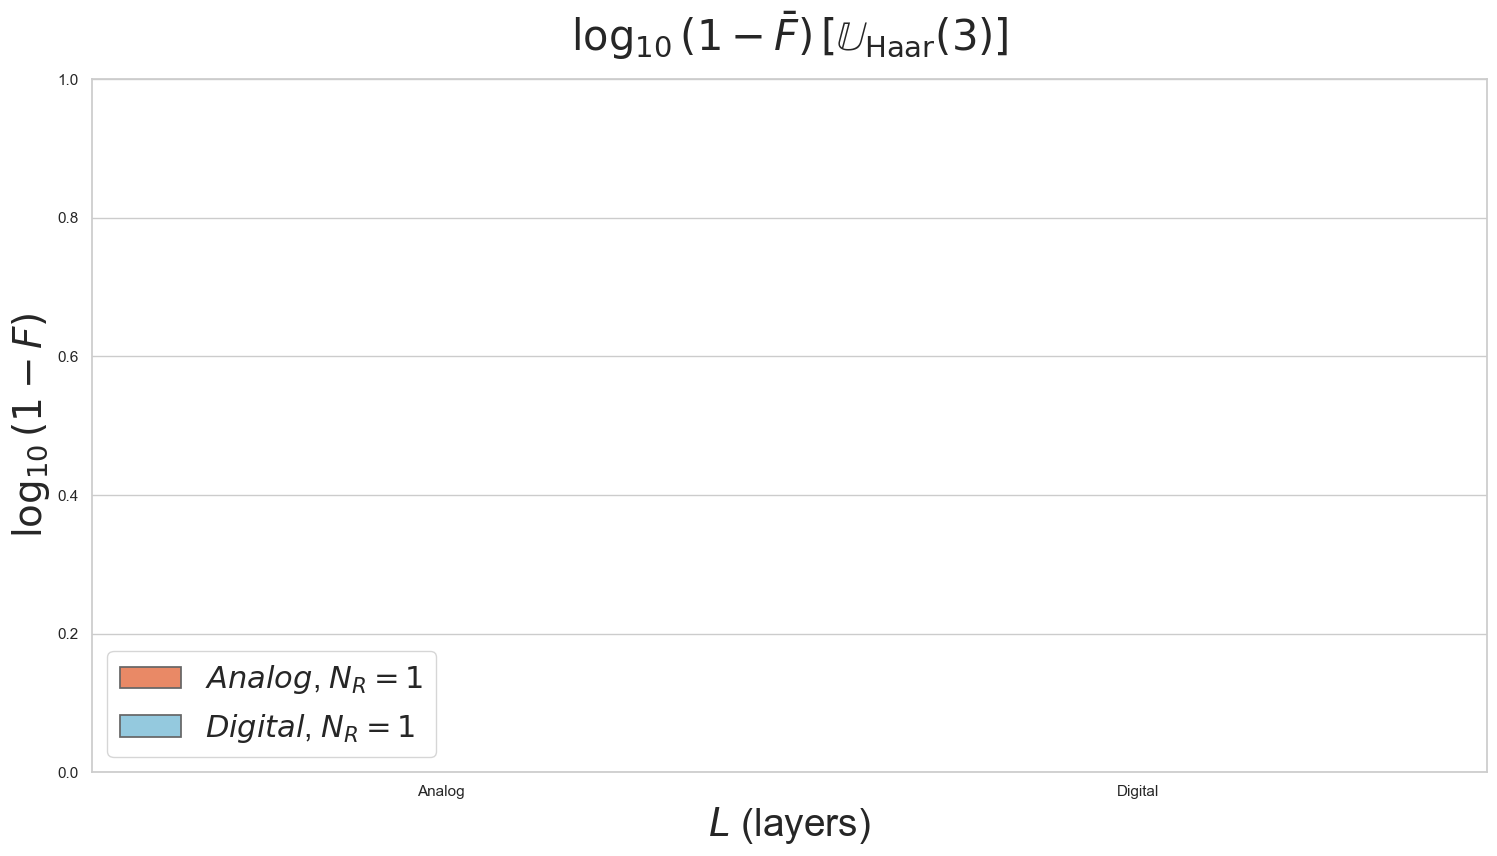

In [40]:

# Custom color palette ensuring consistent color for Analog and Digital
custom_palette = {'Analog': 'coral', 'Digital': 'skyblue'}

# Create the figure and axis for just the second plot
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
sns.set_theme(style="whitegrid")  # Set a theme globally
# sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})


# Create the second plot: Trotter_Step vs Error_Test_Results
sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='Type', data=test_results_df, 
               ax=ax, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)

# Customize the second plot
ax.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
ax.set_xlabel('$L$ (layers)', fontsize=28)
ax.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

# Customizing the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], [f'${label}$, $N_R = 1$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=22)

# Adjust y-tick labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
print(ax.get_xticks())
ax.set_xlim(left = 1,right= max(test_results_df['Trotter_Step'].unique())+1)
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick+1, 1)
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)

# Use unique Trotter_Steps to match the sorted steps for vertical lines
unique_x_ticks = sorted(df_combined['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

# Final plot
plt.tight_layout()
plt.show()
